In [130]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.cluster import KMeans

### Read in Data

In [132]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [133]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Missing Values

In [134]:
miss_vals = pd.DataFrame(df.isna().mean()).reset_index()
miss_vals.columns = ["Columns", "MV Rate"]
miss_vals = miss_vals.sort_values("MV Rate")

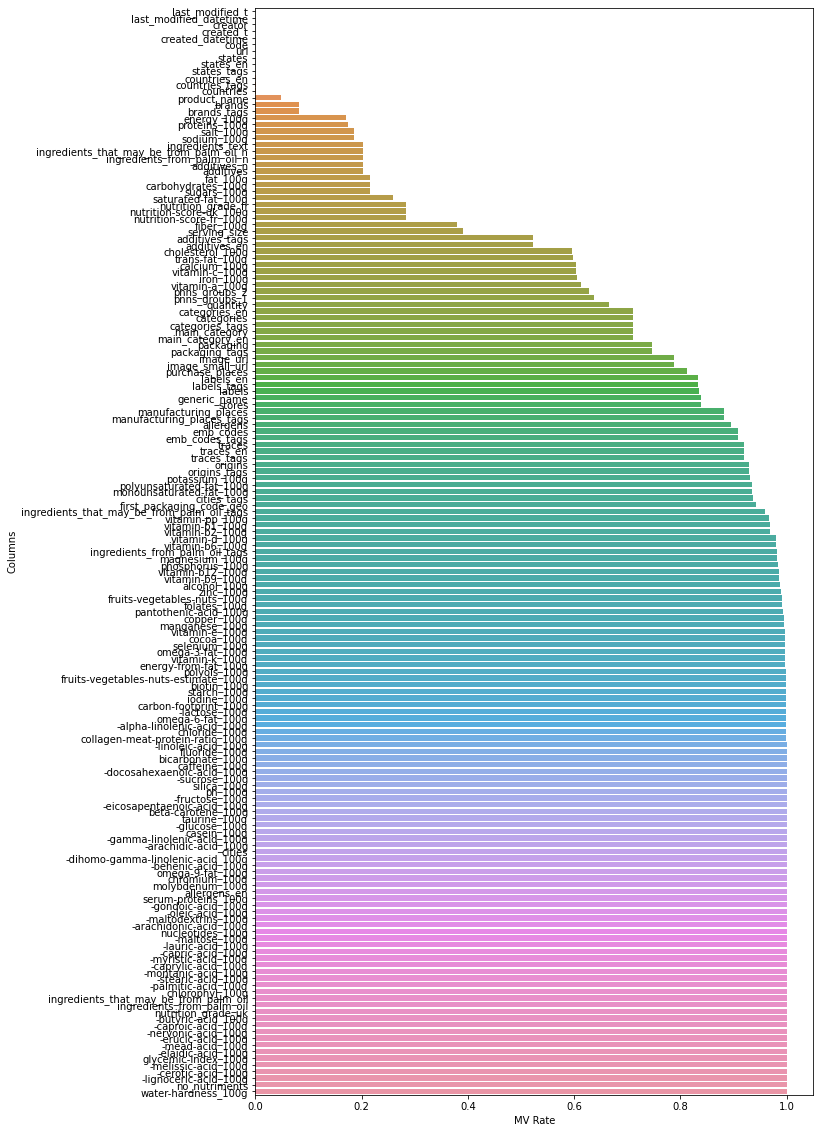

In [135]:
plt.figure(figsize = (20, 10))
sns.barplot("MV Rate", "Columns", data = miss_vals, orient = "h")

### Remove Columns above 30% Missing Values

In [136]:
keep_cols = miss_vals[miss_vals["MV Rate"] < 0.3]["Columns"]

In [137]:
df2 = df[keep_cols]

### Remove General Information 

In [145]:
rm_cols = [ 'last_modified_t',
            'last_modified_datetime',
             'creator',
             'created_t',
             'created_datetime',
             'code',
             'url',
             'states',
             'states_en',
             'states_tags',
             'countries_tags',
             'countries',
             'ingredients_that_may_be_from_palm_oil_n',
             'ingredients_from_palm_oil_n',
             'product_name', ### Perhaps Keep
             'brands', ### Perhaps Keep
             'brands_tags',
             'additives', ### contained in ingredients
             'additives_n',
             'nutrition-score-uk_100g', ### Related to target
             'nutrition_grade_fr', ### Related to target
             'salt_100g' ### Sodium will suffice
          ]

In [146]:
df3 = df2.drop(rm_cols, axis = 1)

## Check Missingness

In [147]:
pd.DataFrame(df3.isna().mean()).reset_index()

,index,0
0,countries_en,0.000772
1,energy_100g,0.170380
2,proteins_100g,0.173768
3,sodium_100g,0.186315
4,ingredients_text,0.202608
5,fat_100g,0.214956
6,carbohydrates_100g,0.215734
7,sugars_100g,0.215829
8,saturated-fat_100g,0.258980
9,nutrition-score-fr_100g,0.284167


### Remove All Missing Rows For Right Now

In [164]:
df4 = df3.dropna()

In [149]:
df4.shape[0] / df3.shape[0]

0.6426394627373767

## Document Term Matrix For Ingredients

Keep only latin letters

In [165]:
ingredients = ["Missing" if pd.isna(ing) else re.sub('[^A-Za-z]', ' ', ing) for ing in df4['ingredients_text']]

List of all words

In [166]:
all_words = [i for ing in ingredients for i in ing.split()]

List of stop words (will be improved later)

In [167]:
rm_words = ['de', 'contains', 's', 'et', 'of', 'en', 'less', 'p']

Keep only the most common words

In [168]:
most_common_words = Counter(all_words).most_common(100)
most_common_words = [word[0] for word in most_common_words if word[0] not in rm_words]

In [169]:
keep_ingredients = [" ".join([word for word in ing.split() if word in most_common_words]) for ing in ingredients ]

Form the document term matrix

In [170]:
vec = CountVectorizer()
X = vec.fit_transform(keep_ingredients)
dtm = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
dtm.to_csv("/Users/gabrieltaylor/Python/STAT542/dtm.csv")
dtm.head()

,acid,acide,amidon,and,ar,artificial,beurre,bl,butter,cacao,...,tournesol,vegetable,vinegar,vitamin,water,wheat,whey,whole,with,yeast
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,3,0,0,0,0


In [171]:
df5 = pd.concat([df4.reset_index(drop = True), dtm], axis = 1)

### Drop Ingredients Column

In [172]:
df6 = df5.drop('ingredients_text', axis = 1)
df6.head()

,countries_en,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g,nutrition-score-fr_100g,acid,...,tournesol,vegetable,vinegar,vitamin,water,wheat,whey,whole,with,yeast
0,United States,2243.0,3.57,0.000,28.57,64.29,14.29,28.57,14.0,0,...,0,1,0,0,0,0,0,0,0,0
1,United States,1941.0,17.86,0.250,17.86,60.71,17.86,0.00,0.0,0,...,0,0,0,0,1,2,0,0,0,0
2,United States,2540.0,17.86,0.482,57.14,17.86,3.57,5.36,12.0,0,...,0,0,0,0,0,0,0,0,0,0
3,United States,1833.0,14.06,0.055,18.75,57.81,15.62,4.69,7.0,0,...,0,0,0,1,0,0,0,0,0,0
4,United States,2230.0,16.67,0.633,36.67,36.67,3.33,5.00,12.0,0,...,0,0,0,0,2,3,0,0,0,0


# Summary Stats

In [173]:
df6.iloc[ : , 1:9].describe()

,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g,nutrition-score-fr_100g
count,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000,228797.000000
mean,1171.881431,7.785698,0.640734,13.319653,32.531768,14.799492,4.880056,9.166230
std,765.953642,8.191208,53.205645,16.262195,28.313047,19.721820,7.407708,8.998898
min,0.000000,-3.570000,0.000000,0.000000,0.000000,-17.860000,0.000000,-15.000000
25%,448.000000,1.770000,0.039370,0.830000,6.670000,1.200000,0.000000,1.000000
50%,1176.000000,5.620000,0.250000,7.100000,22.670000,5.000000,1.790000,10.000000
75%,1707.000000,10.800000,0.536000,21.430000,58.180000,22.580000,7.060000,16.000000
max,14644.000000,305.000000,25320.000000,100.000000,165.000000,145.000000,100.000000,40.000000


### Center and Scale Nutrition Facts

In [174]:
df6.columns[1:8]

Index(['energy_100g', 'proteins_100g', 'sodium_100g', 'fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'saturated-fat_100g'],
      dtype='object')

In [125]:
def scale(x):
    return (x - np.mean(x)) / np.std(x)

In [177]:
### Dont scale nutrition score
for col in df6.columns[1:7]:
    df6[col] = scale(np.array(df6[col]))

In [178]:
df6.iloc[ : , :8].describe()

,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g
count,2.287970e+05,2.287970e+05,2.287970e+05,2.287970e+05,2.287970e+05,2.287970e+05,228797.000000
mean,6.360186e-17,2.514261e-16,-2.562087e-18,1.773896e-16,1.341602e-16,-3.726672e-17,4.880056
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,7.407708
min,-1.529967e+00,-1.386331e+00,-1.204263e-02,-8.190580e-01,-1.149005e+00,-1.656012e+00,0.000000
25%,-9.450742e-01,-7.344107e-01,-1.130267e-02,-7.680193e-01,-9.134243e-01,-6.895673e-01,0.000000
50%,5.377058e-03,-2.643935e-01,-7.343869e-03,-3.824617e-01,-3.483125e-01,-4.968868e-01,1.790000
75%,6.986320e-01,3.679932e-01,-1.968488e-03,4.987251e-01,9.058823e-01,3.945136e-01,7.060000
max,1.758873e+01,3.628463e+01,4.758783e+02,5.330187e+00,4.678709e+00,6.601865e+00,100.000000


# Unsupervised Task

## Clustering Macronutrients by Country

In [255]:
keep_cols = ['countries_en', 'carbohydrates_100g', 'proteins_100g', 'fat_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna()

In [256]:
clust_df['countries_en'].value_counts().head(6)

United States     170268
France             76040
Switzerland        10590
Germany             4992
Spain               3101
United Kingdom      1604
Name: countries_en, dtype: int64

In [257]:
clust_df = clust_df[clust_df.countries_en.isin(['United States', 'France', 'Switzerland', 'Germany', 'Spain', 'United Kingdom'])]

Relabel countries

In [258]:
clust_df['countries_en'] = ['US' if c == 'United States' else 'EU' for c in clust_df['countries_en']]

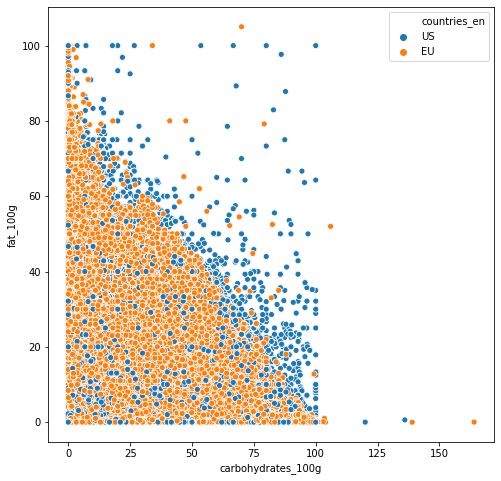

In [239]:
plt.figure(figsize=(8, 8))
sns.scatterplot('carbohydrates_100g', 'fat_100g', data = clust_df, hue = 'countries_en')

### Kmeans

In [259]:
X = np.array(clust_df.drop('countries_en', axis = 1))
kmeans = KMeans(n_clusters = 2, random_state = 69).fit(X)

In [260]:
true_labs = list(map(lambda x: 1 if x == 'US' else 0, clust_df['countries_en']))

In [261]:
np.mean(kmeans.labels_ != true_labs)

0.5006920609913914

## Clustering Macronutrients by Nutrition Score

In [283]:
keep_cols = ['nutrition-score-fr_100g', 'carbohydrates_100g', 'proteins_100g', 'fat_100g']
clust_df = df[keep_cols]
clust_df = clust_df.dropna()

In [284]:
for col in clust_df:
    clust_df[col] = scale(clust_df[col])

In [285]:
clust_df.describe()

,nutrition-score-fr_100g,carbohydrates_100g,proteins_100g,fat_100g
count,2.385330e+05,2.385330e+05,2.385330e+05,2.385330e+05
mean,1.050922e-16,2.983569e-16,9.657278e-17,3.848613e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.686037e+00,-1.147781e+00,-1.386897e+00,-8.189967e-01
25%,-9.084462e-01,-9.117348e-01,-7.314661e-01,-7.650828e-01
50%,9.144848e-02,-3.525844e-01,-2.594579e-01,-3.815594e-01
75%,7.580450e-01,9.047962e-01,3.592887e-01,4.939278e-01
max,3.424431e+00,4.691448e+00,3.634564e+01,1.143415e+01


In [286]:
true_labs = list(map(lambda x: 1 if x > 0.5 else 0, clust_df['nutrition-score-fr_100g']))
clust_df['nutrition-score-fr_100g'] = true_labs

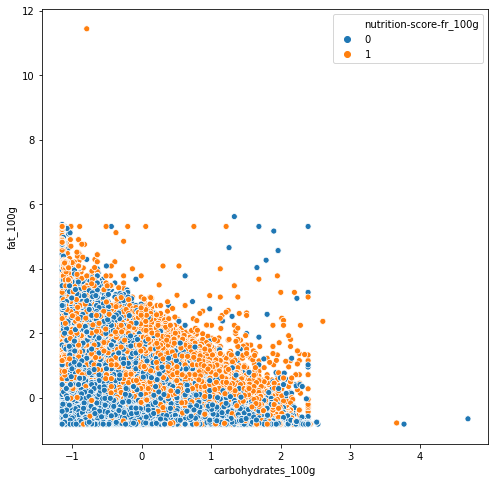

In [280]:
plt.figure(figsize=(8, 8))
sns.scatterplot('carbohydrates_100g', 'fat_100g', data = clust_df, hue = 'nutrition-score-fr_100g')

### Kmeans

In [287]:
X = np.array(clust_df.drop('nutrition-score-fr_100g', axis = 1))
kmeans = KMeans(n_clusters = 2, random_state = 69).fit(X)

In [288]:
np.mean(kmeans.labels_ == true_labs)

0.6683142374430372

# Supervised Task